## Observed data, clustering with KMeans

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from kmeans import k_means
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "kmeans_observed_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning K-Means for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    for k in [3, 4, 5, 6, 7]:
        result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
            k_means, "K-Means", normalized_data, data_min, data_max, k, plot=False
        )

        unnormalized_data, cluster_centers = unnormalize(result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
        plotter.clusters_2d_plot(f"K-Means: years = {year_range}, k = {k}", os.path.join(plot_dir, f"kmeans_{year_range}_k{k}.png"))

        results.append({
            "Year Range": year_range, "k": k, "Runtime (s)": f"{time_kmeans:.3f}", "Clusters": n_clusters_kmeans,
            "Points per Cluster": points_per_cluster_kmeans,
            "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans else None,
            "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans else None,
            "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans else None,
            "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans else None
        })
    
    display(pd.DataFrame(results))

## Observed data, clustering with DBSCAN

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from DBSCAN import dbscan_clustering  # Assuming you have a DBSCAN implementation
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "dbscan_observed_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning DBSCAN for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    eps_values = [0.02, 0.01, 0.015, 0.05]
    min_samples_values = [10, 15, 20, 25]
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )

            unnormalized_data, cluster_centers = unnormalize(result_dbscan.data, result_dbscan.cluster_centers, data_min, data_max)
            plotter = ClusterPlotter(unnormalized_data, result_dbscan.labels, cluster_centers)
            plotter.clusters_2d_plot(
                f"DBSCAN: years = {year_range}, eps = {eps}, min_samples = {min_samples}",
                os.path.join(plot_dir, f"dbscan_{year_range}_eps{eps}_min{min_samples}.png")
            )

            results.append({
                "Year Range": year_range, "eps": eps, "min_samples": min_samples, "Runtime (s)": f"{time_dbscan:.3f}",
                "Clusters": n_clusters_dbscan, "Points per Cluster": points_per_cluster_dbscan,
                "Davies-Bouldin": f"{metrics_dbscan[0]:.3f}" if metrics_dbscan else None,
                "Calinski-Harabasz": f"{metrics_dbscan[1]:.3f}" if metrics_dbscan else None,
                "Dunn Index": f"{metrics_dbscan[2]:.3f}" if metrics_dbscan else None,
                "Silhouette Score": f"{metrics_dbscan[3]:.3f}" if metrics_dbscan else None
            })
    
    display(pd.DataFrame(results))


## Observed data, clustering with DBSCAN with GridSearch

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from DBSCAN import dbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

plot_dir = "dbscan_grid_search_normal_bins_observed"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

results_per_year_range = {}

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # DBSCAN parameter grid
    eps_values = [0.01, 0.012, 0.015, 0.018, 0.02, 0.023, 0.05]
    min_samples_values = [7, 10, 15, 20, 30]
    
    best_result = None
    best_score = float('-inf')
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )
            
            silhouette_score = metrics_dbscan[3] if metrics_dbscan and isinstance(metrics_dbscan[3], (int, float)) else None
            noise_points = np.sum(result_dbscan.labels == -1)

            if silhouette_score is not None and silhouette_score > best_score:
                best_score = silhouette_score
                best_result = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "runtime": time_dbscan,
                    "clusters": n_clusters_dbscan,
                    "points_per_cluster": points_per_cluster_dbscan,
                    "noise_points": noise_points,
                    "metrics": metrics_dbscan,
                    "result_dbscan": result_dbscan
                }

    # Plot and store only the best result
    if best_result:
        unnormalized_data, _ = unnormalize(best_result["result_dbscan"].data, None, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, best_result["result_dbscan"].labels, None)
        plot_filename = os.path.join(plot_dir, f"dbscan_{year_range}_best.png")
        title = f"DBSCAN Best: {year_range}, eps = {best_result['eps']}, min_samples = {best_result['min_samples']}"
        plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
        
        results_per_year_range[year_range] = best_result
        
        print(f"Best for {year_range}: eps = {best_result['eps']}, min_samples = {best_result['min_samples']}, silhouette = {best_score:.3f}")

final_results = [
    {"Year Range": yr, "Eps": res["eps"], "Min Samples": res["min_samples"], "Silhouette Score": f"{res['metrics'][3]:.3f}", "Noise Points": res["noise_points"]}
    for yr, res in results_per_year_range.items()
]
df = pd.DataFrame(final_results)
display(df)

## Observed data, clustering with OPTICS

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

plot_dir = "Images/optics_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning OPTICS for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_samples_values = [50, 100, 200, 400, 500]
    max_eps_vals = [100, 1000, np.inf]
    xi_vals = [0.001, 0.002, 0.005]

    results = []

    for min_sample in min_samples_values: 
        for max_eps in max_eps_vals:
            for xi in xi_vals:
                result_optics, time_optics, n_clusters_optics, points_per_cluster_optics, metrics_optics = run_clustering(
                    optics_clustering, "OPTICS", normalized_data, data_min, data_max,
                    min_samples=min_sample, max_eps=max_eps, xi=xi,
                    plot_reachability=False, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_optics.data, result_optics.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_optics.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"optics_{year_range}_min{min_sample}_maxeps{max_eps}_xi{xi}.png")
                title = f"OPTICS: years = {year_range}, min: {min_sample}, maxeps: {max_eps}, xi: {xi}"
                plotter.clusters_2d_plot(title, plot_filename)

                # Handle empty metrics
                if isinstance(metrics_optics, (list, np.ndarray)) and np.array(metrics_optics).size == 0:
                    metrics_optics = np.array([0, 0, 0, 0, 0, 0, 0])

                # Initialize default values
                rounded_cluster_std = None
                rounded_square_density = None
                rounded_hull_density = None

                # Safely round metric dicts if available
                if isinstance(metrics_optics[4], dict):
                    rounded_cluster_std = {
                        key: tuple(round(val, 3) for val in value)
                        for key, value in metrics_optics[4].items()
                    }

                if isinstance(metrics_optics[5], dict):
                    rounded_square_density = {
                        key: round(value, 3)
                        for key, value in metrics_optics[5].items()
                    }

                if isinstance(metrics_optics[6], dict):
                    rounded_hull_density = {
                        key: round(value, 3)
                        for key, value in metrics_optics[6].items()
                    }

                is_valid_metrics = (
                    isinstance(metrics_optics, np.ndarray)
                    and metrics_optics.shape == (7,)
                    and all(isinstance(metrics_optics[i], (int, float)) for i in range(4))
                )

                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_optics,
                    "Runtime (s)": f"{time_optics:.3f}",
                    "Clusters": n_clusters_optics,
                    "Points per Cluster": points_per_cluster_optics,
                    "Davies-Bouldin": f"{metrics_optics[0]:.3f}" if is_valid_metrics else None,
                    "Calinski-Harabasz": f"{metrics_optics[1]:.3f}" if is_valid_metrics else None,
                    "Dunn Index": f"{metrics_optics[2]:.3f}" if is_valid_metrics else None,
                    "Silhouette Score": f"{metrics_optics[3]:.3f}" if is_valid_metrics else None,
                    "Cluster Std.": rounded_cluster_std,
                    "Square Density": rounded_square_density,
                    "Hull Density": rounded_hull_density
                })

    df = pd.DataFrame(results)
    display(df)


{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running OPTICS for Year Range: 2002-2005
Runtime for optics_clustering: 5.907874 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min200_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.480944 seconds
Plot

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,8,5.908,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",None,None,None,None,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
1,2002-2005,8,5.481,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",None,None,None,None,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
2,2002-2005,8,6.373,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",None,None,None,None,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
3,2002-2005,8,8.086,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",None,None,None,None,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
4,2002-2005,5,5.628,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",None,None,None,None,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
5,2002-2005,5,5.017,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",None,None,None,None,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
6,2002-2005,5,5.162,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",None,None,None,None,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
7,2002-2005,5,4.974,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",None,None,None,None,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
8,2002-2005,5,5.145,5,"{0: 1571, 1: 671, 2: 730, 3: 579, -1: 2801}",None,None,None,None,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2801.0, 0: 33882.077, 1: 23066.642, 2: 21...","{-1: 2872.743, 0: 44667.352, 1: 34154.123, 2: ..."
9,2002-2005,5,5.103,5,"{0: 1571, 1: 671, 2: 724, 3: 579, -1: 2807}",None,None,None,None,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2807.0, 0: 33882.077, 1: 23066.642, 2: 22...","{-1: 2878.897, 0: 44667.352, 1: 34154.123, 2: ..."



Running OPTICS for Year Range: 2006-2009
Runtime for optics_clustering: 5.749491 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.131930 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxeps1000_xi0.002.png
Runtime for optics_clustering: 5.985942 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxepsinf_xi0.001.png
Runtime for optics_clustering: 5.902896 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxepsinf_xi0.002.png
Runtime for optics_clustering: 5.251594 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.169655 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxeps1000_xi0.002.png
Runtime for optics_clustering: 5.010496 seconds
Plot saved as: Ima

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,5,5.749,5,"{0: 411, 1: 1054, 2: 424, 3: 231, -1: 3425}",None,None,None,None,"{-1: (0.173, 0.228), 0: (0.013, 0.016), 1: (0....","{-1: 3425.0, 0: 97363.56, 1: 52622.862, 2: 118...","{-1: 3518.302, 0: 133802.303, 1: 73469.063, 2:..."
1,2006-2009,5,5.132,5,"{0: 400, 1: 1054, 2: 424, 3: 231, -1: 3436}",None,None,None,None,"{-1: (0.173, 0.228), 0: (0.012, 0.016), 1: (0....","{-1: 3436.0, 0: 101753.076, 1: 52622.862, 2: 1...","{-1: 3529.602, 0: 139825.176, 1: 73469.063, 2:..."
2,2006-2009,5,5.986,5,"{0: 411, 1: 1054, 2: 424, 3: 231, -1: 3425}",None,None,None,None,"{-1: (0.173, 0.228), 0: (0.013, 0.016), 1: (0....","{-1: 3425.0, 0: 97363.56, 1: 52622.862, 2: 118...","{-1: 3518.302, 0: 133802.303, 1: 73469.063, 2:..."
3,2006-2009,5,5.903,5,"{0: 400, 1: 1054, 2: 424, 3: 231, -1: 3436}",None,None,None,None,"{-1: (0.173, 0.228), 0: (0.012, 0.016), 1: (0....","{-1: 3436.0, 0: 101753.076, 1: 52622.862, 2: 1...","{-1: 3529.602, 0: 139825.176, 1: 73469.063, 2:..."
4,2006-2009,3,5.252,3,"{0: 1372, 1: 1292, -1: 2881}",None,None,None,None,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
5,2006-2009,3,5.170,3,"{0: 1372, 1: 1292, -1: 2881}",None,None,None,None,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
6,2006-2009,3,5.010,3,"{0: 1372, 1: 1292, -1: 2881}",None,None,None,None,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
7,2006-2009,3,5.287,3,"{0: 1372, 1: 1292, -1: 2881}",None,None,None,None,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
8,2006-2009,3,5.007,3,"{0: 1445, 1: 1304, -1: 2796}",None,None,None,None,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"
9,2006-2009,3,5.274,3,"{0: 1445, 1: 1304, -1: 2796}",None,None,None,None,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"



Running OPTICS for Year Range: 2010-2013
Runtime for optics_clustering: 1.949609 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.108360 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.721038 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.802247 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxepsinf_xi0.002.png
Runtime for optics_clustering: 2.145085 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.465334 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.267272 seconds
Plot saved as: Ima

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,3,1.950,3,"{0: 899, 1: 458, -1: 767}",None,None,None,None,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
1,2010-2013,3,2.108,3,"{0: 899, 1: 458, -1: 767}",None,None,None,None,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
2,2010-2013,3,1.721,3,"{0: 899, 1: 458, -1: 767}",None,None,None,None,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
3,2010-2013,3,1.802,3,"{0: 899, 1: 458, -1: 767}",None,None,None,None,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
4,2010-2013,2,2.145,2,"{0: 989, -1: 1135}",None,None,None,None,"{-1: (0.18, 0.221), 0: (0.059, 0.081)}","{-1: 1135.0, 0: 7387.864}","{-1: 1262.314, 0: 9525.071}"
5,2010-2013,2,2.465,2,"{0: 980, -1: 1144}",None,None,None,None,"{-1: (0.179, 0.221), 0: (0.059, 0.079)}","{-1: 1144.0, 0: 7475.833}","{-1: 1272.324, 0: 9523.244}"
6,2010-2013,2,2.267,2,"{0: 989, -1: 1135}",None,None,None,None,"{-1: (0.18, 0.221), 0: (0.059, 0.081)}","{-1: 1135.0, 0: 7387.864}","{-1: 1262.314, 0: 9525.071}"
7,2010-2013,2,2.866,2,"{0: 980, -1: 1144}",None,None,None,None,"{-1: (0.179, 0.221), 0: (0.059, 0.079)}","{-1: 1144.0, 0: 7475.833}","{-1: 1272.324, 0: 9523.244}"
8,2010-2013,2,2.496,2,"{0: 1041, -1: 1083}",None,None,None,None,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"
9,2010-2013,2,2.511,2,"{0: 1041, -1: 1083}",None,None,None,None,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"



Running OPTICS for Year Range: 2014-2017
Runtime for optics_clustering: 1.584018 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.934727 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.474587 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.365928 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.988574 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min400_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.583020 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min400_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.804846 seconds
Plot saved as: Ima

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,2,1.584,2,"{0: 835, -1: 718}",None,None,None,None,"{-1: (0.228, 0.249), 0: (0.085, 0.127)}","{-1: 718.0, 0: 3889.249}","{-1: 796.037, 0: 5087.265}"
1,2014-2017,2,1.935,2,"{0: 835, -1: 718}",None,None,None,None,"{-1: (0.228, 0.249), 0: (0.085, 0.127)}","{-1: 718.0, 0: 3889.249}","{-1: 796.037, 0: 5087.265}"
2,2014-2017,2,1.475,2,"{0: 835, -1: 718}",None,None,None,None,"{-1: (0.228, 0.249), 0: (0.085, 0.127)}","{-1: 718.0, 0: 3889.249}","{-1: 796.037, 0: 5087.265}"
3,2014-2017,2,1.366,2,"{0: 835, -1: 718}",None,None,None,None,"{-1: (0.228, 0.249), 0: (0.085, 0.127)}","{-1: 718.0, 0: 3889.249}","{-1: 796.037, 0: 5087.265}"
4,2014-2017,1,1.989,1,{0: 1553},None,None,None,None,None,None,None
5,2014-2017,1,1.583,1,{0: 1553},None,None,None,None,None,None,None
6,2014-2017,1,1.805,1,{0: 1553},None,None,None,None,None,None,None
7,2014-2017,1,1.784,1,{0: 1553},None,None,None,None,None,None,None
8,2014-2017,1,1.755,1,{0: 1553},None,None,None,None,None,None,None
9,2014-2017,1,1.930,1,{0: 1553},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2019-2023
Runtime for optics_clustering: 3.856767 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min200_maxeps1000_xi0.001.png
Runtime for optics_clustering: 3.475616 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min200_maxeps1000_xi0.002.png
Runtime for optics_clustering: 3.484584 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min200_maxepsinf_xi0.001.png
Runtime for optics_clustering: 3.265599 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min200_maxepsinf_xi0.002.png
Runtime for optics_clustering: 4.115204 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min400_maxeps1000_xi0.001.png
Runtime for optics_clustering: 3.748309 seconds
Plot saved as: Images/optics_observations_normal_bins\optics_2019-2023_min400_maxeps1000_xi0.002.png
Runtime for optics_clustering: 3.728471 seconds
Plot saved as: Ima

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2023,3,3.857,3,"{0: 425, 1: 756, -1: 2244}",None,None,None,None,"{-1: (0.203, 0.25), 0: (0.015, 0.038), 1: (0.0...","{-1: 2244.0, 0: 31478.527, 1: 4281.72}","{-1: 2292.399, 0: 38121.615, 1: 6240.244}"
1,2019-2023,3,3.476,3,"{0: 425, 1: 756, -1: 2244}",None,None,None,None,"{-1: (0.203, 0.25), 0: (0.015, 0.038), 1: (0.0...","{-1: 2244.0, 0: 31478.527, 1: 4281.72}","{-1: 2292.399, 0: 38121.615, 1: 6240.244}"
2,2019-2023,3,3.485,3,"{0: 425, 1: 756, -1: 2244}",None,None,None,None,"{-1: (0.203, 0.25), 0: (0.015, 0.038), 1: (0.0...","{-1: 2244.0, 0: 31478.527, 1: 4281.72}","{-1: 2292.399, 0: 38121.615, 1: 6240.244}"
3,2019-2023,3,3.266,3,"{0: 425, 1: 756, -1: 2244}",None,None,None,None,"{-1: (0.203, 0.25), 0: (0.015, 0.038), 1: (0.0...","{-1: 2244.0, 0: 31478.527, 1: 4281.72}","{-1: 2292.399, 0: 38121.615, 1: 6240.244}"
4,2019-2023,3,4.115,3,"{0: 2072, 1: 605, -1: 748}",None,None,None,None,"{-1: (0.291, 0.343), 0: (0.108, 0.155), 1: (0....","{-1: 748.0, 0: 5077.898, 1: 3984.995}","{-1: 764.133, 0: 6908.554, 1: 5658.77}"
5,2019-2023,3,3.748,3,"{0: 2017, 1: 605, -1: 803}",None,None,None,None,"{-1: (0.288, 0.336), 0: (0.105, 0.152), 1: (0....","{-1: 803.0, 0: 5356.35, 1: 3984.995}","{-1: 820.319, 0: 7244.954, 1: 5658.77}"
6,2019-2023,3,3.728,3,"{0: 2072, 1: 605, -1: 748}",None,None,None,None,"{-1: (0.291, 0.343), 0: (0.108, 0.155), 1: (0....","{-1: 748.0, 0: 5077.898, 1: 3984.995}","{-1: 764.133, 0: 6908.554, 1: 5658.77}"
7,2019-2023,3,3.672,3,"{0: 2017, 1: 605, -1: 803}",None,None,None,None,"{-1: (0.288, 0.336), 0: (0.105, 0.152), 1: (0....","{-1: 803.0, 0: 5356.35, 1: 3984.995}","{-1: 820.319, 0: 7244.954, 1: 5658.77}"
8,2019-2023,2,4.429,2,"{0: 2166, -1: 1259}",None,None,None,None,"{-1: (0.224, 0.3), 0: (0.117, 0.155)}","{-1: 1259.0, 0: 4998.716}","{-1: 1286.154, 0: 6795.393}"
9,2019-2023,2,3.753,2,"{0: 2135, -1: 1290}",None,None,None,None,"{-1: (0.227, 0.298), 0: (0.116, 0.153)}","{-1: 1290.0, 0: 5146.416}","{-1: 1317.823, 0: 6960.662}"


## Observed data, clustering with HDBSCAN

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running HDBSCAN for Year Range: 2002-2005
Runtime for hdbscan_clustering: 0.421643 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2002-2005_minclust50_minsamplesNone_epsilon0.0.png
Runtime for hdbscan_clustering: 0.370

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,7,0.422,7,"{0: 249, 1: 375, 2: 1309, 3: 589, 4: 288, 5: 4...",4.059,607.827,0.000,0.015,"{-1: (0.2, 0.261), 0: (0.071, 0.102), 1: (0.01...","{-1: 3098.0, 0: 2163.934, 1: 33357.23, 2: 3884...","{-1: 3177.371, 0: 2786.062, 1: 56530.015, 2: 7..."
1,2002-2005,7,0.370,7,"{0: 249, 1: 375, 2: 1309, 3: 589, 4: 288, 5: 4...",4.059,607.827,0.000,0.015,"{-1: (0.2, 0.261), 0: (0.071, 0.102), 1: (0.01...","{-1: 3098.0, 0: 2163.934, 1: 33357.23, 2: 3884...","{-1: 3177.371, 0: 2786.062, 1: 56530.015, 2: 7..."
2,2002-2005,3,0.382,3,"{0: 249, 1: 5410, -1: 693}",2.706,637.553,0.000,0.142,"{-1: (0.283, 0.328), 0: (0.071, 0.102), 1: (0....","{-1: 693.0, 0: 2163.934, 1: 8797.518}","{-1: 710.755, 0: 2786.062, 1: 12676.18}"
3,2002-2005,3,0.436,3,"{0: 249, 1: 5410, -1: 693}",2.706,637.553,0.000,0.142,"{-1: (0.283, 0.328), 0: (0.071, 0.102), 1: (0....","{-1: 693.0, 0: 2163.934, 1: 8797.518}","{-1: 710.755, 0: 2786.062, 1: 12676.18}"
4,2002-2005,16,0.381,16,"{0: 60, 1: 172, 2: 105, 3: 58, 4: 76, 5: 97, 6...",3.377,359.753,0.000,-0.040,"{-1: (0.183, 0.255), 0: (0.043, 0.047), 1: (0....","{-1: 2913.231, 0: 1566.277, 1: 2605.595, 2: 62...","{-1: 3025.091, 0: 2672.338, 1: 3980.406, 2: 11..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2002-2005,3,0.748,3,"{0: 396, 1: 5520, -1: 436}",2.551,882.969,0.001,0.156,"{-1: (0.271, 0.321), 0: (0.104, 0.116), 1: (0....","{-1: 436.184, 0: 2233.904, 1: 8142.08}","{-1: 447.321, 0: 2914.188, 1: 11460.434}"
60,2002-2005,3,0.932,3,"{0: 376, 1: 5504, -1: 472}",2.566,818.957,0.003,0.161,"{-1: (0.274, 0.336), 0: (0.1, 0.115), 1: (0.08...","{-1: 472.199, 0: 2264.769, 1: 8160.96}","{-1: 484.23, 0: 3002.069, 1: 11791.919}"
61,2002-2005,3,0.838,3,"{0: 376, 1: 5504, -1: 472}",2.566,818.957,0.003,0.161,"{-1: (0.274, 0.336), 0: (0.1, 0.115), 1: (0.08...","{-1: 472.199, 0: 2264.769, 1: 8160.96}","{-1: 484.23, 0: 3002.069, 1: 11791.919}"
62,2002-2005,3,0.890,3,"{0: 376, 1: 5504, -1: 472}",2.566,818.957,0.003,0.161,"{-1: (0.274, 0.336), 0: (0.1, 0.115), 1: (0.08...","{-1: 472.199, 0: 2264.769, 1: 8160.96}","{-1: 484.23, 0: 3002.069, 1: 11791.919}"



Running HDBSCAN for Year Range: 2006-2009
Runtime for hdbscan_clustering: 1.144016 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.0.png
Runtime for hdbscan_clustering: 1.007978 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 1.191922 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 1.428278 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.5.png
Runtime for hdbscan_clustering: 2.148310 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamples5_epsilon0.0.png
Runtime for hdbscan_clustering: 1.377055 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2006-2009_minclust50_minsamples5

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,8,1.144,8,"{0: 59, 1: 173, 2: 197, 3: 100, 4: 784, 5: 135...",2.178,145.706,0.000,-0.153,"{-1: (0.182, 0.231), 0: (0.01, 0.017), 1: (0.0...","{-1: 3308.0, 0: 23314.479, 1: 25820.02, 2: 215...","{-1: 3398.115, 0: 35101.578, 1: 38084.869, 2: ..."
1,2006-2009,8,1.008,8,"{0: 59, 1: 173, 2: 197, 3: 100, 4: 784, 5: 135...",2.178,145.706,0.000,-0.153,"{-1: (0.182, 0.231), 0: (0.01, 0.017), 1: (0.0...","{-1: 3308.0, 0: 23314.479, 1: 25820.02, 2: 215...","{-1: 3398.115, 0: 35101.578, 1: 38084.869, 2: ..."
2,2006-2009,3,1.192,3,"{0: 59, 1: 3205, -1: 2281}",4.144,117.976,0.001,-0.312,"{-1: (0.209, 0.259), 0: (0.01, 0.017), 1: (0.0...","{-1: 2281.0, 0: 23314.479, 1: 14269.626}","{-1: 2343.138, 0: 35101.578, 1: 25159.198}"
3,2006-2009,3,1.428,3,"{0: 59, 1: 3205, -1: 2281}",4.144,117.976,0.001,-0.312,"{-1: (0.209, 0.259), 0: (0.01, 0.017), 1: (0.0...","{-1: 2281.0, 0: 23314.479, 1: 14269.626}","{-1: 2343.138, 0: 35101.578, 1: 25159.198}"
4,2006-2009,19,2.148,19,"{0: 68, 1: 52, 2: 61, 3: 57, 4: 200, 5: 86, 6:...",1.623,123.245,0.000,-0.159,"{-1: (0.184, 0.222), 0: (0.018, 0.084), 1: (0....","{-1: 2898.0, 0: 2649.058, 1: 3418.551, 2: 1410...","{-1: 2976.946, 0: 5163.648, 1: 5841.902, 2: 29..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2006-2009,3,0.783,3,"{0: 192, 1: 2580, -1: 2773}",2.978,243.763,0.001,-0.186,"{-1: (0.194, 0.25), 0: (0.012, 0.029), 1: (0.0...","{-1: 2773.0, 0: 23472.171, 1: 21223.987}","{-1: 2848.541, 0: 43907.627, 1: 41666.724}"
60,2006-2009,5,2.021,5,"{0: 187, 1: 206, 2: 727, 3: 1072, -1: 3353}",2.411,186.097,0.000,-0.090,"{-1: (0.181, 0.235), 0: (0.008, 0.031), 1: (0....","{-1: 3353.0, 0: 22113.75, 1: 23974.841, 2: 694...","{-1: 3444.341, 0: 41056.717, 1: 45925.714, 2: ..."
61,2006-2009,4,0.919,4,"{0: 187, 1: 206, 2: 2328, -1: 2824}",2.791,181.676,0.000,-0.212,"{-1: (0.192, 0.248), 0: (0.008, 0.031), 1: (0....","{-1: 2824.0, 0: 22113.75, 1: 23974.841, 2: 264...","{-1: 2900.93, 0: 41056.717, 1: 45925.714, 2: 6..."
62,2006-2009,3,0.756,3,"{0: 187, 1: 2579, -1: 2779}",2.986,245.584,0.000,-0.186,"{-1: (0.194, 0.25), 0: (0.008, 0.031), 1: (0.0...","{-1: 2779.0, 0: 22113.75, 1: 21851.345}","{-1: 2854.704, 0: 41056.717, 1: 43841.782}"



Running HDBSCAN for Year Range: 2010-2013
Runtime for hdbscan_clustering: 0.695383 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.0.png
Runtime for hdbscan_clustering: 0.985765 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.791203 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.784647 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.5.png
Runtime for hdbscan_clustering: 0.637076 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamples5_epsilon0.0.png
Runtime for hdbscan_clustering: 0.773261 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2010-2013_minclust50_minsamples5

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,6,0.695,6,"{0: 117, 1: 52, 2: 312, 3: 93, 4: 559, -1: 991}",1.906,140.968,0.001,0.037,"{-1: (0.18, 0.262), 0: (0.01, 0.033), 1: (0.00...","{-1: 991.0, 0: 10203.202, 1: 16602.394, 2: 302...","{-1: 1102.161, 0: 26966.082, 1: 33137.833, 2: ..."
1,2010-2013,6,0.986,6,"{0: 117, 1: 52, 2: 312, 3: 93, 4: 559, -1: 991}",1.906,140.968,0.001,0.037,"{-1: (0.18, 0.262), 0: (0.01, 0.033), 1: (0.00...","{-1: 991.0, 0: 10203.202, 1: 16602.394, 2: 302...","{-1: 1102.161, 0: 26966.082, 1: 33137.833, 2: ..."
2,2010-2013,3,0.791,3,"{0: 117, 1: 1156, -1: 851}",2.545,146.028,0.001,-0.134,"{-1: (0.189, 0.276), 0: (0.01, 0.033), 1: (0.0...","{-1: 851.0, 0: 10203.202, 1: 8524.198}","{-1: 946.458, 0: 26966.082, 1: 16320.559}"
3,2010-2013,3,0.785,3,"{0: 117, 1: 1156, -1: 851}",2.545,146.028,0.001,-0.134,"{-1: (0.189, 0.276), 0: (0.01, 0.033), 1: (0.0...","{-1: 851.0, 0: 10203.202, 1: 8524.198}","{-1: 946.458, 0: 26966.082, 1: 16320.559}"
4,2010-2013,12,0.637,12,"{0: 86, 1: 65, 2: 53, 3: 139, 4: 94, 5: 59, 6:...",1.752,135.988,0.000,0.002,"{-1: (0.164, 0.237), 0: (0.06, 0.085), 1: (0.0...","{-1: 948.0, 0: 1404.485, 1: 3582.365, 2: 25869...","{-1: 1054.593, 0: 2349.973, 1: 5525.468, 2: 36..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2010-2013,3,0.509,3,"{0: 343, 1: 866, -1: 915}",2.404,214.958,0.000,-0.041,"{-1: (0.184, 0.282), 0: (0.01, 0.047), 1: (0.0...","{-1: 915.0, 0: 25065.83, 1: 9762.83}","{-1: 1017.636, 0: 39355.88, 1: 16720.0}"
60,2010-2013,3,0.525,3,"{0: 345, 1: 908, -1: 871}",2.431,232.551,0.000,-0.024,"{-1: (0.187, 0.284), 0: (0.01, 0.047), 1: (0.0...","{-1: 871.0, 0: 25455.284, 1: 8462.296}","{-1: 968.701, 0: 35714.268, 1: 14703.495}"
61,2010-2013,3,0.493,3,"{0: 345, 1: 908, -1: 871}",2.431,232.551,0.000,-0.024,"{-1: (0.187, 0.284), 0: (0.01, 0.047), 1: (0.0...","{-1: 871.0, 0: 25455.284, 1: 8462.296}","{-1: 968.701, 0: 35714.268, 1: 14703.495}"
62,2010-2013,3,0.493,3,"{0: 345, 1: 908, -1: 871}",2.431,232.551,0.000,-0.024,"{-1: (0.187, 0.284), 0: (0.01, 0.047), 1: (0.0...","{-1: 871.0, 0: 25455.284, 1: 8462.296}","{-1: 968.701, 0: 35714.268, 1: 14703.495}"



Running HDBSCAN for Year Range: 2014-2017
Runtime for hdbscan_clustering: 0.557618 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.0.png
Runtime for hdbscan_clustering: 0.587206 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.582074 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.610598 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.5.png
Runtime for hdbscan_clustering: 0.666684 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamples5_epsilon0.0.png
Runtime for hdbscan_clustering: 0.626141 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2014-2017_minclust50_minsamples5

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,3,0.558,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
1,2014-2017,3,0.587,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
2,2014-2017,3,0.582,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
3,2014-2017,3,0.611,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
4,2014-2017,5,0.667,5,"{0: 77, 1: 82, 2: 106, 3: 426, -1: 862}",3.107,68.736,0.001,-0.140,"{-1: (0.215, 0.276), 0: (0.026, 0.049), 1: (0....","{-1: 862.0, 0: 3439.803, 1: 8072.795, 2: 7095....","{-1: 955.688, 0: 5847.994, 1: 9934.289, 2: 109..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2014-2017,1,0.477,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None
60,2014-2017,1,0.589,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None
61,2014-2017,1,0.464,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None
62,2014-2017,1,0.445,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2019-2023
Runtime for hdbscan_clustering: 0.996838 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamplesNone_epsilon0.0.png
Runtime for hdbscan_clustering: 1.176917 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.984966 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.988455 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamplesNone_epsilon0.5.png
Runtime for hdbscan_clustering: 0.939257 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamples5_epsilon0.0.png
Runtime for hdbscan_clustering: 0.954143 seconds
Plot saved as: Images\hdbscan_observations_normal_bins\hdbscan_2019-2023_minclust50_minsamples5

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2023,6,0.997,6,"{0: 499, 1: 167, 2: 60, 3: 68, 4: 675, -1: 1956}",1.987,155.985,0.000,-0.125,"{-1: (0.23, 0.264), 0: (0.031, 0.12), 1: (0.01...","{-1: 1956.0, 0: 5198.438, 1: 13190.826, 2: 672...","{-1: 1998.187, 0: 9205.601, 1: 20727.279, 2: 1..."
1,2019-2023,6,1.177,6,"{0: 499, 1: 167, 2: 60, 3: 68, 4: 675, -1: 1956}",1.987,155.985,0.000,-0.125,"{-1: (0.23, 0.264), 0: (0.031, 0.12), 1: (0.01...","{-1: 1956.0, 0: 5198.438, 1: 13190.826, 2: 672...","{-1: 1998.187, 0: 9205.601, 1: 20727.279, 2: 1..."
2,2019-2023,3,0.985,3,"{0: 499, 1: 1382, -1: 1544}",2.747,333.655,0.001,-0.067,"{-1: (0.249, 0.282), 0: (0.031, 0.12), 1: (0.0...","{-1: 1544.0, 0: 5198.438, 1: 5531.496}","{-1: 1577.301, 0: 9205.601, 1: 9285.421}"
3,2019-2023,3,0.988,3,"{0: 499, 1: 1382, -1: 1544}",2.747,333.655,0.001,-0.067,"{-1: (0.249, 0.282), 0: (0.031, 0.12), 1: (0.0...","{-1: 1544.0, 0: 5198.438, 1: 5531.496}","{-1: 1577.301, 0: 9205.601, 1: 9285.421}"
4,2019-2023,12,0.939,12,"{0: 78, 1: 189, 2: 801, 3: 59, 4: 54, 5: 74, 6...",1.970,144.707,0.000,-0.067,"{-1: (0.229, 0.279), 0: (0.024, 0.054), 1: (0....","{-1: 1450.0, 0: 3996.242, 1: 10572.917, 2: 408...","{-1: 1481.402, 0: 5653.195, 1: 14715.734, 2: 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-2023,3,0.529,3,"{0: 260, 1: 2437, -1: 728}",5.521,188.905,0.000,-0.137,"{-1: (0.296, 0.314), 0: (0.037, 0.069), 1: (0....","{-1: 728.0, 0: 4824.853, 1: 4167.213}","{-1: 743.766, 0: 7441.564, 1: 6003.192}"
60,2019-2023,4,0.441,4,"{0: 240, 1: 613, 2: 1286, -1: 1286}",2.653,336.921,0.000,-0.014,"{-1: (0.248, 0.294), 0: (0.037, 0.065), 1: (0....","{-1: 1286.0, 0: 4646.934, 1: 3748.151, 2: 5267...","{-1: 1313.737, 0: 7596.501, 1: 6463.18, 2: 909..."
61,2019-2023,4,0.411,4,"{0: 240, 1: 613, 2: 1286, -1: 1286}",2.653,336.921,0.000,-0.014,"{-1: (0.248, 0.294), 0: (0.037, 0.065), 1: (0....","{-1: 1286.0, 0: 4646.934, 1: 3748.151, 2: 5267...","{-1: 1313.737, 0: 7596.501, 1: 6463.18, 2: 909..."
62,2019-2023,3,0.387,3,"{0: 240, 1: 2300, -1: 885}",8.437,153.582,0.001,-0.165,"{-1: (0.286, 0.306), 0: (0.037, 0.065), 1: (0....","{-1: 885.0, 0: 4646.934, 1: 4391.456}","{-1: 904.088, 0: 7596.501, 1: 6049.889}"


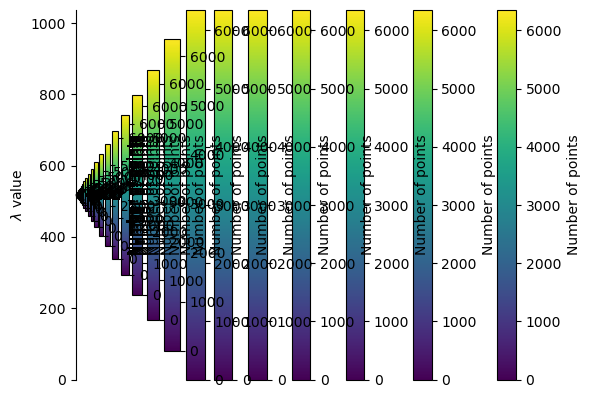

In [6]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from HDBSCAN import hdbscan_clustering
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

# Set directories for saving plots
images_dir = "Images"
os.makedirs(images_dir, exist_ok=True)
plot_dir = os.path.join(images_dir, "hdbscan_observations_normal_bins")
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

# Start clustering for each year range
for cluster_data, year_range in binned_data:
    print(f"\nRunning HDBSCAN for Year Range: {year_range}")

    # Prepare data
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # Parameter grids for HDBSCAN
    min_cluster_size_values = [50, 100, 150, 180]
    min_samples_values = [None, 5, 10, 15]
    cluster_selection_epsilon_values = [0.0, 0.01, 0.1, 0.5]

    results = []

    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:
            for cluster_selection_epsilon in cluster_selection_epsilon_values:
                result_hdbscan, time_hdbscan, n_clusters_hdbscan, points_per_cluster_hdbscan, metrics_hdbscan = run_clustering(
                    hdbscan_clustering, "HDBSCAN", normalized_data, data_min, data_max,
                    min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon,
                    plot_condensed_tree=True, plot=False
                )

                # Check for empty or invalid metrics
                if isinstance(metrics_hdbscan, (list, np.ndarray)) and np.array(metrics_hdbscan).size == 0:
                    metrics_hdbscan = [0, 0, 0, 0, 0, 0, 0]

                # Unnormalize data and cluster centers
                unnormalized_data, cluster_centers = unnormalize(
                    result_hdbscan.data, result_hdbscan.cluster_centers, data_min, data_max
                )

                # Plot the results
                plotter = ClusterPlotter(unnormalized_data, result_hdbscan.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"hdbscan_{year_range}_minclust{min_cluster_size}_minsamples{min_samples}_epsilon{cluster_selection_epsilon}.png")
                title = f"HDBSCAN: years = {year_range}, min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, epsilon: {cluster_selection_epsilon},"
                plotter.clusters_2d_plot(title, plot_filename)

                # Safely handle metrics and round them
                rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_hdbscan[4].items()} if isinstance(metrics_hdbscan[4], dict) else None
                rounded_square_density = {key: round(value, 3) for key, value in metrics_hdbscan[5].items()} if isinstance(metrics_hdbscan[5], dict) else None
                rounded_hull_density = {key: round(value, 3) for key, value in metrics_hdbscan[6].items()} if isinstance(metrics_hdbscan[6], dict) else None

                # Prepare results for this set of parameters
                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_hdbscan,
                    "Runtime (s)": f"{time_hdbscan:.3f}",
                    "Clusters": n_clusters_hdbscan,
                    "Points per Cluster": points_per_cluster_hdbscan,
                    "Davies-Bouldin": f"{metrics_hdbscan[0]:.3f}" if isinstance(metrics_hdbscan[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_hdbscan[1]:.3f}" if isinstance(metrics_hdbscan[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_hdbscan[2]:.3f}" if isinstance(metrics_hdbscan[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_hdbscan[3]:.3f}" if isinstance(metrics_hdbscan[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std,
                    "Square Density": rounded_square_density,
                    "Hull Density": rounded_hull_density
                })

    # Save results to DataFrame
    df = pd.DataFrame(results)
    display(df)


## Observed data, clustering with DENCLUE

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from clustering_utils import ClusteringResult
from scipy.spatial.distance import cdist
from DENCLUE import denclue_clustering  # Import DENCLUE clustering function
from cluster_plotter import ClusterPlotter

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

plot_dir = "Images/denclue_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DENCLUE for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    epsilon_vals = [5, 10, 20]
    max_iter_vals = [100, 200]
    bandwidth_vals = [0.001, 0.005, 0.01]

    results = []

    for epsilon in epsilon_vals:
        for max_iter in max_iter_vals:
            for bandwidth in bandwidth_vals:
                result_denclue, time_denclue, n_clusters_denclue, points_per_cluster_denclue, metrics_denclue = run_clustering(
                    denclue_clustering, "DENCLUE",
                    normalized_data, data_min, data_max, epsilon=epsilon, max_iter=max_iter, bandwidth=bandwidth, plot=False
                )

                # Check if the clustering result contains any clusters
                if len(result_denclue.cluster_centers) > 0:
                    unnormalized_data, cluster_centers = unnormalize(
                        result_denclue.data, result_denclue.cluster_centers, data_min, data_max
                    )
                    plotter = ClusterPlotter(unnormalized_data, result_denclue.labels, None)
                    plot_filename = os.path.join(plot_dir, f"denclue_{year_range}_eps{epsilon}_maxiter{max_iter}_bandwidth{bandwidth}.png")
                    title = f"DENCLUE: years = {year_range}, epsilon: {epsilon}, max_iter: {max_iter}, bandwidth: {bandwidth}"
                    plotter.clusters_2d_plot(title, plot_filename, show_centers=False)

                    rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_denclue[4].items()}
                    rounded_square_density = {key: round(value, 3) for key, value in metrics_denclue[5].items()}
                    rounded_hull_density = {key: round(value, 3) for key, value in metrics_denclue[6].items()}

                    results.append({
                        "Year Range": year_range,
                        "k": n_clusters_denclue,
                        "Runtime (s)": f"{time_denclue:.3f}",
                        "Clusters": n_clusters_denclue,
                        "Points per Cluster": points_per_cluster_denclue,
                        "Davies-Bouldin": f"{metrics_denclue[0]:.3f}" if metrics_denclue and isinstance(metrics_denclue[0], (int, float)) else None,
                        "Calinski-Harabasz": f"{metrics_denclue[1]:.3f}" if metrics_denclue and isinstance(metrics_denclue[1], (int, float)) else None,
                        "Dunn Index": f"{metrics_denclue[2]:.3f}" if metrics_denclue and isinstance(metrics_denclue[2], (int, float)) else None,
                        "Silhouette Score": f"{metrics_denclue[3]:.3f}" if metrics_denclue and isinstance(metrics_denclue[3], (int, float)) else None,
                        "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                        "Square Density": rounded_square_density if rounded_square_density else None,
                        "Hull Density": rounded_hull_density if rounded_hull_density else None
                    })
                else:
                    print(f"No clusters formed for epsilon={epsilon}, max_iter={max_iter}, bandwidth={bandwidth}. Skipping plotting and results.")
                    # Adding a default entry for cases with no clusters formed
                    results.append({
                        "Year Range": year_range,
                        "k": 0,
                        "Runtime (s)": None,
                        "Clusters": 0,
                        "Points per Cluster": None,
                        "Davies-Bouldin": None,
                        "Calinski-Harabasz": None,
                        "Dunn Index": None,
                        "Silhouette Score": None,
                        "Cluster Std.": None,
                        "Square Density": None,
                        "Hull Density": None
                    })

    # Convert results to DataFrame and display
    df = pd.DataFrame(results)
    display(df)

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running DENCLUE for Year Range: 2002-2005
Runtime for denclue_clustering: 0.841866 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 2.112659 se

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,2,0.842,2,"{-1.0: 5484, 1159.0: 868}",11.415,14.473,0.000,-0.400,"{-1.0: (0.191, 0.234), 1159.0: (0.063, 0.21)}","{-1.0: 5484.0, 1159.0: 1872.356}","{-1.0: 5624.464, 1159.0: 3666.131}"
1,2002-2005,2,2.113,2,"{5589.0: 3506, -1.0: 2846}",7.254,96.390,0.000,-0.198,"{-1.0: (0.242, 0.258), 5589.0: (0.087, 0.209)}","{-1.0: 2846.0, 5589.0: 4386.018}","{-1.0: 2918.896, 5589.0: 7870.402}"
2,2002-2005,2,2.377,2,"{5638.0: 4834, -1.0: 1518}",8.035,72.903,0.002,-0.096,"{-1.0: (0.254, 0.295), 5638.0: (0.119, 0.222)}","{-1.0: 1518.118, 5638.0: 5645.568}","{-1.0: 1558.621, 5638.0: 7931.475}"
3,2002-2005,2,2.450,2,"{-1.0: 5484, 1159.0: 868}",11.415,14.473,0.000,-0.400,"{-1.0: (0.191, 0.234), 1159.0: (0.063, 0.21)}","{-1.0: 5484.0, 1159.0: 1872.356}","{-1.0: 5624.464, 1159.0: 3666.131}"
4,2002-2005,2,3.763,2,"{5589.0: 3506, -1.0: 2846}",7.254,96.390,0.000,-0.198,"{-1.0: (0.242, 0.258), 5589.0: (0.087, 0.209)}","{-1.0: 2846.0, 5589.0: 4386.018}","{-1.0: 2918.896, 5589.0: 7870.402}"
5,2002-2005,2,0.944,2,"{5638.0: 4834, -1.0: 1518}",8.035,72.903,0.002,-0.096,"{-1.0: (0.254, 0.295), 5638.0: (0.119, 0.222)}","{-1.0: 1518.118, 5638.0: 5645.568}","{-1.0: 1558.621, 5638.0: 7931.475}"
6,2002-2005,2,1.216,2,"{-1.0: 6054, 1159.0: 298}",58.999,0.207,0.000,-0.431,"{-1.0: (0.183, 0.232), 1159.0: (0.052, 0.215)}","{-1.0: 6054.0, 1159.0: 1646.254}","{-1.0: 6209.063, 1159.0: 6048.746}"
7,2002-2005,2,1.125,2,"{5589.0: 2583, -1.0: 3769}",6.384,106.490,0.000,-0.270,"{-1.0: (0.225, 0.246), 5589.0: (0.062, 0.203)}","{-1.0: 3769.0, 5589.0: 5738.426}","{-1.0: 3865.537, 5589.0: 10973.765}"
8,2002-2005,2,0.943,2,"{5638.0: 3904, -1.0: 2448}",6.413,128.697,0.001,-0.143,"{-1.0: (0.258, 0.273), 5638.0: (0.071, 0.207)}","{-1.0: 2448.0, 5638.0: 5907.604}","{-1.0: 2510.702, 5638.0: 9575.407}"
9,2002-2005,2,1.026,2,"{-1.0: 6054, 1159.0: 298}",58.999,0.207,0.000,-0.431,"{-1.0: (0.183, 0.232), 1159.0: (0.052, 0.215)}","{-1.0: 6054.0, 1159.0: 1646.254}","{-1.0: 6209.063, 1159.0: 6048.746}"



Running DENCLUE for Year Range: 2006-2009
Runtime for denclue_clustering: 0.854702 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.754382 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.629362 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.691624 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.704576 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.605090 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,2,0.855,2,"{4027.0: 346, -1.0: 5199}",6.746,11.883,0.000,-0.515,"{-1.0: (0.153, 0.203), 4027.0: (0.06, 0.097)}","{-1.0: 5199.0, 4027.0: 4285.218}","{-1.0: 5340.629, 4027.0: 6881.502}"
1,2006-2009,2,0.754,2,"{4027.0: 2998, -1.0: 2547}",4.156,239.271,0.000,-0.161,"{-1.0: (0.199, 0.241), 4027.0: (0.086, 0.136)}","{-1.0: 2547.0, 4027.0: 8211.989}","{-1.0: 2616.384, 4027.0: 13226.327}"
2,2006-2009,2,0.629,2,"{4042.0: 4187, -1.0: 1358}",5.675,137.458,0.002,-0.030,"{-1.0: (0.251, 0.269), 4042.0: (0.096, 0.163)}","{-1.0: 1358.0, 4042.0: 5582.964}","{-1.0: 1394.994, 4042.0: 9025.002}"
3,2006-2009,2,0.692,2,"{4027.0: 346, -1.0: 5199}",6.746,11.883,0.000,-0.515,"{-1.0: (0.153, 0.203), 4027.0: (0.06, 0.097)}","{-1.0: 5199.0, 4027.0: 4285.218}","{-1.0: 5340.629, 4027.0: 6881.502}"
4,2006-2009,2,0.705,2,"{4027.0: 2998, -1.0: 2547}",4.156,239.271,0.000,-0.161,"{-1.0: (0.199, 0.241), 4027.0: (0.086, 0.136)}","{-1.0: 2547.0, 4027.0: 8211.989}","{-1.0: 2616.384, 4027.0: 13226.327}"
5,2006-2009,2,0.605,2,"{4042.0: 4187, -1.0: 1358}",5.675,137.458,0.002,-0.030,"{-1.0: (0.251, 0.269), 4042.0: (0.096, 0.163)}","{-1.0: 1358.0, 4042.0: 5582.964}","{-1.0: 1394.994, 4042.0: 9025.002}"
6,2006-2009,2,0.669,2,"{4027.0: 46, -1.0: 5499}",9.286,0.799,0.000,-0.586,"{-1.0: (0.151, 0.198), 4027.0: (0.018, 0.094)}","{-1.0: 5499.0, 4027.0: 1937.494}","{-1.0: 5648.801, 4027.0: 6200.612}"
7,2006-2009,2,0.667,2,"{4027.0: 2191, -1.0: 3354}",4.585,158.103,0.000,-0.261,"{-1.0: (0.18, 0.23), 4027.0: (0.081, 0.121)}","{-1.0: 3354.0, 4027.0: 9606.738}","{-1.0: 3445.368, 4027.0: 17151.524}"
8,2006-2009,2,0.631,2,"{4042.0: 3457, -1.0: 2088}",4.028,273.969,0.001,-0.094,"{-1.0: (0.215, 0.254), 4042.0: (0.088, 0.139)}","{-1.0: 2088.0, 4042.0: 10475.505}","{-1.0: 2144.88, 4042.0: 17523.666}"
9,2006-2009,2,0.629,2,"{4027.0: 46, -1.0: 5499}",9.286,0.799,0.000,-0.586,"{-1.0: (0.151, 0.198), 4027.0: (0.018, 0.094)}","{-1.0: 5499.0, 4027.0: 1937.494}","{-1.0: 5648.801, 4027.0: 6200.612}"



Running DENCLUE for Year Range: 2010-2013
Runtime for denclue_clustering: 0.129363 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.146102 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.096054 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.099658 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.114532 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.139092 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,2,0.129,2,"{-1.0: 2013, 239.0: 111}",3.389,17.708,0.000,-0.470,"{-1.0: (0.142, 0.215), 239.0: (0.069, 0.129)}","{-1.0: 2013.0, 239.0: 851.594}","{-1.0: 2238.8, 239.0: 1549.389}"
1,2010-2013,2,0.146,2,"{1374.0: 1233, -1.0: 891}",3.227,158.850,0.000,-0.176,"{-1.0: (0.181, 0.25), 1374.0: (0.083, 0.166)}","{-1.0: 891.0, 1374.0: 2609.36}","{-1.0: 990.944, 1374.0: 4272.95}"
2,2010-2013,2,0.096,2,"{1830.0: 1555, -1.0: 569}",3.158,159.399,0.002,-0.073,"{-1.0: (0.208, 0.266), 1830.0: (0.098, 0.175)}","{-1.0: 569.0, 1830.0: 2282.709}","{-1.0: 632.825, 1830.0: 4216.361}"
3,2010-2013,2,0.100,2,"{-1.0: 2013, 239.0: 111}",3.389,17.708,0.000,-0.470,"{-1.0: (0.142, 0.215), 239.0: (0.069, 0.129)}","{-1.0: 2013.0, 239.0: 851.594}","{-1.0: 2238.8, 239.0: 1549.389}"
4,2010-2013,2,0.115,2,"{1374.0: 1233, -1.0: 891}",3.227,158.850,0.000,-0.176,"{-1.0: (0.181, 0.25), 1374.0: (0.083, 0.166)}","{-1.0: 891.0, 1374.0: 2609.36}","{-1.0: 990.944, 1374.0: 4272.95}"
5,2010-2013,2,0.139,2,"{1830.0: 1555, -1.0: 569}",3.158,159.399,0.002,-0.073,"{-1.0: (0.208, 0.266), 1830.0: (0.098, 0.175)}","{-1.0: 569.0, 1830.0: 2282.709}","{-1.0: 632.825, 1830.0: 4216.361}"
6,2010-2013,0,None,0,None,None,None,None,None,None,None,None
7,2010-2013,2,0.098,2,"{1374.0: 703, -1.0: 1421}",4.101,70.015,0.000,-0.321,"{-1.0: (0.159, 0.236), 1374.0: (0.06, 0.146)}","{-1.0: 1421.0, 1374.0: 4350.689}","{-1.0: 1580.395, 1374.0: 8142.683}"
8,2010-2013,2,0.084,2,"{1830.0: 1309, -1.0: 815}",2.344,306.072,0.000,-0.094,"{-1.0: (0.191, 0.253), 1830.0: (0.074, 0.153)}","{-1.0: 815.0, 1830.0: 6380.631}","{-1.0: 906.419, 1830.0: 9578.622}"
9,2010-2013,0,None,0,None,None,None,None,None,None,None,None



Running DENCLUE for Year Range: 2014-2017
Runtime for denclue_clustering: 0.064934 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.111418 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.061567 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.068043 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.066592 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.051925 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,2,0.065,2,"{976.0: 53, -1.0: 1500}",1.797,50.048,0.000,-0.103,"{-1.0: (0.163, 0.235), 976.0: (0.171, 0.237)}","{-1.0: 1500.0, 976.0: 115.881}","{-1.0: 1663.031, 976.0: 259.729}"
1,2014-2017,2,0.111,2,"{979.0: 229, -1.0: 1324}",15.473,2.960,0.000,-0.222,"{-1.0: (0.162, 0.23), 979.0: (0.204, 0.271)}","{-1.0: 1324.0, 979.0: 394.313}","{-1.0: 1467.902, 979.0: 738.014}"
2,2014-2017,2,0.062,2,"{979.0: 755, -1.0: 798}",11.958,8.154,0.000,-0.267,"{-1.0: (0.192, 0.245), 979.0: (0.139, 0.227)}","{-1.0: 798.0, 979.0: 945.441}","{-1.0: 884.732, 979.0: 1845.486}"
3,2014-2017,2,0.068,2,"{976.0: 53, -1.0: 1500}",1.797,50.048,0.000,-0.103,"{-1.0: (0.163, 0.235), 976.0: (0.171, 0.237)}","{-1.0: 1500.0, 976.0: 115.881}","{-1.0: 1663.031, 976.0: 259.729}"
4,2014-2017,2,0.067,2,"{979.0: 229, -1.0: 1324}",15.473,2.960,0.000,-0.222,"{-1.0: (0.162, 0.23), 979.0: (0.204, 0.271)}","{-1.0: 1324.0, 979.0: 394.313}","{-1.0: 1467.902, 979.0: 738.014}"
5,2014-2017,2,0.052,2,"{979.0: 755, -1.0: 798}",11.958,8.154,0.000,-0.267,"{-1.0: (0.192, 0.245), 979.0: (0.139, 0.227)}","{-1.0: 798.0, 979.0: 945.441}","{-1.0: 884.732, 979.0: 1845.486}"
6,2014-2017,2,0.054,2,"{976.0: 23, -1.0: 1530}",0.570,54.570,0.000,-0.054,"{-1.0: (0.164, 0.236), 976.0: (0.0, 0.001)}","{-1.0: 1530.0, 976.0: 4305687.14}","{-1.0: 1696.291, 976.0: 6913936.633}"
7,2014-2017,2,0.046,2,"{979.0: 71, -1.0: 1482}",1.579,103.840,0.004,-0.017,"{-1.0: (0.159, 0.23), 979.0: (0.06, 0.32)}","{-1.0: 1482.0, 979.0: 462.044}","{-1.0: 1643.074, 979.0: 1216.156}"
8,2014-2017,2,0.048,2,"{979.0: 273, -1.0: 1280}",17.981,2.191,0.001,-0.258,"{-1.0: (0.167, 0.232), 979.0: (0.174, 0.26)}","{-1.0: 1280.0, 979.0: 506.124}","{-1.0: 1419.12, 979.0: 1040.473}"
9,2014-2017,2,0.054,2,"{976.0: 23, -1.0: 1530}",0.570,54.570,0.000,-0.054,"{-1.0: (0.164, 0.236), 976.0: (0.0, 0.001)}","{-1.0: 1530.0, 976.0: 4305687.14}","{-1.0: 1696.291, 976.0: 6913936.633}"



Running DENCLUE for Year Range: 2019-2023
Runtime for denclue_clustering: 0.278944 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.277235 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.243983 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.251559 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.257273 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.261816 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2023,2,0.279,2,"{2917.0: 120, -1.0: 3305}",2.623,17.981,0.000,-0.550,"{-1.0: (0.207, 0.223), 2917.0: (0.006, 0.057)}","{-1.0: 3305.0, 2917.0: 2395.909}","{-1.0: 3376.283, 2917.0: 27912.184}"
1,2019-2023,2,0.277,2,"{2606.0: 956, -1.0: 2469}",3.632,114.461,0.000,-0.293,"{-1.0: (0.223, 0.244), 2606.0: (0.111, 0.132)}","{-1.0: 2469.0, 2606.0: 2123.463}","{-1.0: 2522.252, 2606.0: 3162.873}"
2,2019-2023,2,0.244,2,"{2708.0: 2054, -1.0: 1371}",7.146,55.545,0.001,-0.190,"{-1.0: (0.251, 0.27), 2708.0: (0.15, 0.186)}","{-1.0: 1371.0, 2708.0: 2804.284}","{-1.0: 1400.57, 2708.0: 3992.551}"
3,2019-2023,2,0.252,2,"{2917.0: 120, -1.0: 3305}",2.623,17.981,0.000,-0.550,"{-1.0: (0.207, 0.223), 2917.0: (0.006, 0.057)}","{-1.0: 3305.0, 2917.0: 2395.909}","{-1.0: 3376.283, 2917.0: 27912.184}"
4,2019-2023,2,0.257,2,"{2606.0: 956, -1.0: 2469}",3.632,114.461,0.000,-0.293,"{-1.0: (0.223, 0.244), 2606.0: (0.111, 0.132)}","{-1.0: 2469.0, 2606.0: 2123.463}","{-1.0: 2522.252, 2606.0: 3162.873}"
5,2019-2023,2,0.262,2,"{2708.0: 2054, -1.0: 1371}",7.146,55.545,0.001,-0.190,"{-1.0: (0.251, 0.27), 2708.0: (0.15, 0.186)}","{-1.0: 1371.0, 2708.0: 2804.284}","{-1.0: 1400.57, 2708.0: 3992.551}"
6,2019-2023,2,0.235,2,"{2917.0: 16, -1.0: 3409}",2.445,2.168,0.001,-0.606,"{-1.0: (0.204, 0.221), 2917.0: (0.0, 0.0)}","{-1.0: 3409.0, 2917.0: 48181564.652}","{-1.0: 3482.526, 2917.0: 92862064.54}"
7,2019-2023,2,0.296,2,"{2606.0: 480, -1.0: 2945}",2.342,105.365,0.000,-0.394,"{-1.0: (0.215, 0.234), 2606.0: (0.04, 0.059)}","{-1.0: 2945.0, 2606.0: 9998.531}","{-1.0: 3008.518, 2606.0: 19668.843}"
8,2019-2023,2,0.262,2,"{2708.0: 1198, -1.0: 2227}",3.661,141.045,0.000,-0.249,"{-1.0: (0.227, 0.252), 2708.0: (0.114, 0.141)}","{-1.0: 2227.0, 2708.0: 2958.953}","{-1.0: 2275.032, 2708.0: 4771.629}"
9,2019-2023,2,0.274,2,"{2917.0: 16, -1.0: 3409}",2.445,2.168,0.001,-0.606,"{-1.0: (0.204, 0.221), 2917.0: (0.0, 0.0)}","{-1.0: 3409.0, 2917.0: 48181564.652}","{-1.0: 3482.526, 2917.0: 92862064.54}"
